In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS=set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


EDA

In [4]:
data=pd.read_csv('/content/amazon_alexa.tsv',delimiter='\t',quoting=3) # Changed delimiter to \t


In [5]:
data.shape

(3150, 5)

In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
data.columns.values

array(['rating', 'date', 'variation', 'verified_reviews', 'feedback'],
      dtype=object)

In [8]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [9]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [10]:
data.dropna(inplace=True)

In [11]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,0
feedback,0


In [12]:
data.shape

(3149, 5)

In [13]:
data['length']=data['verified_reviews'].apply(len)

In [14]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [15]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


In [16]:
data['rating'].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,95


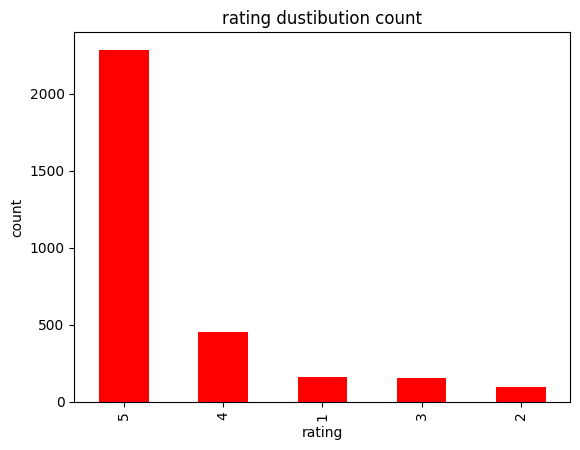

In [17]:
data['rating'].value_counts().plot.bar(color='red')
plt.title('rating dustibution count')
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

In [18]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


In [19]:
data[data['feedback']==0].iloc[1]['verified_reviews']

'Sound is terrible if u want good music too get a bose'

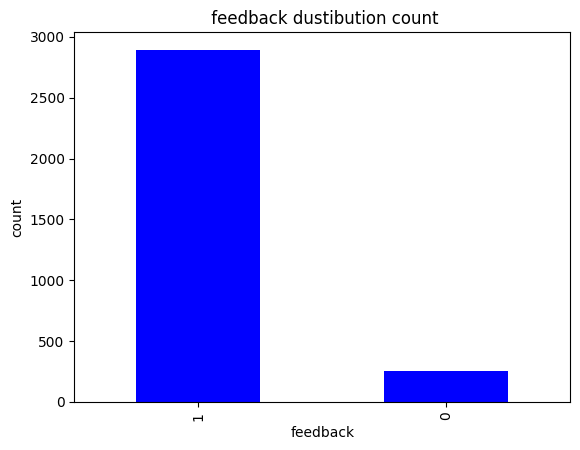

In [20]:
data['feedback'].value_counts().plot.bar(color='blue')
plt.title(' feedback dustibution count')
plt.xlabel('feedback')
plt.ylabel('count')
plt.show()

In [21]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


In [22]:
data[data['feedback']==1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


In [23]:
data['variation'].value_counts()

,count
variation,
Black Dot,516
Charcoal Fabric,430
Configuration: Fire TV Stick,350
Black Plus,270
Black Show,265
Black,261
Black Spot,241
White Dot,184
Heather Gray Fabric,157


In [24]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


In [25]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'Distribution of lenght of review')]

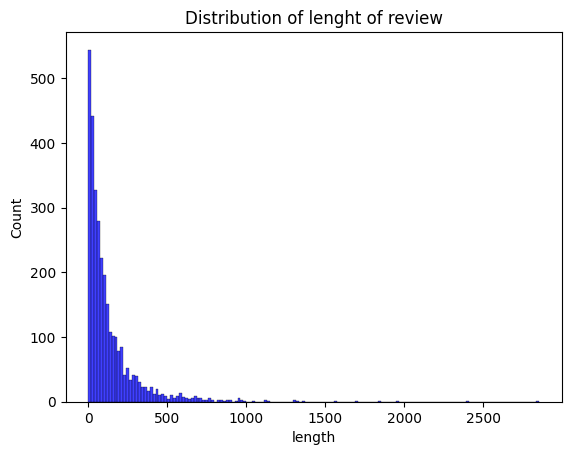

In [26]:
sns.histplot(data['length'],color= 'blue').set(title='Distribution of lenght of review')

[Text(0.5, 1.0, 'Distribution of lenght of review')]

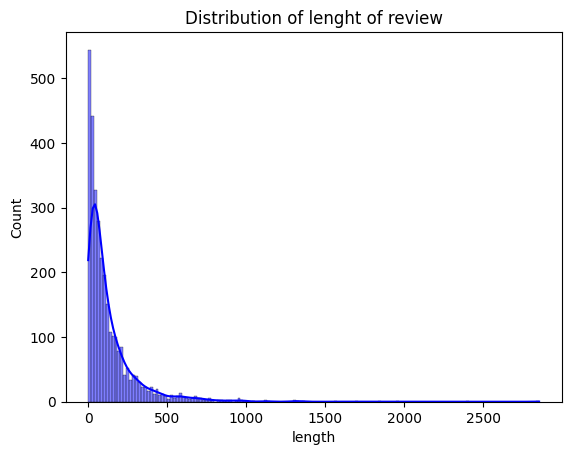

In [27]:
sns.histplot(data['length'],color= 'blue',kde=True).set(title='Distribution of lenght of review')

[Text(0.5, 1.0, 'Distribution of lenght of review if feedback=0')]

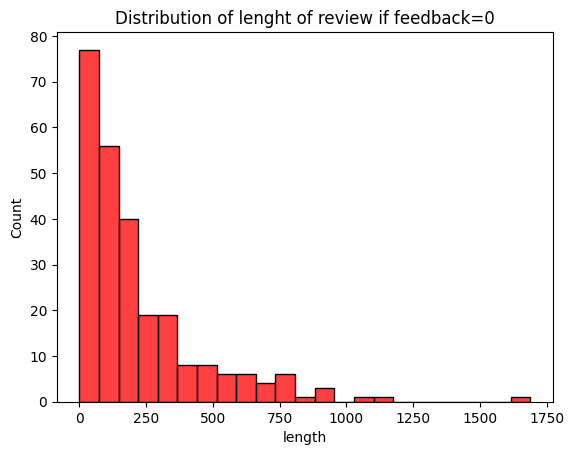

In [28]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of lenght of review if feedback=0')

In [29]:
cv=CountVectorizer(stop_words='english')
words=cv.fit_transform(data.verified_reviews)

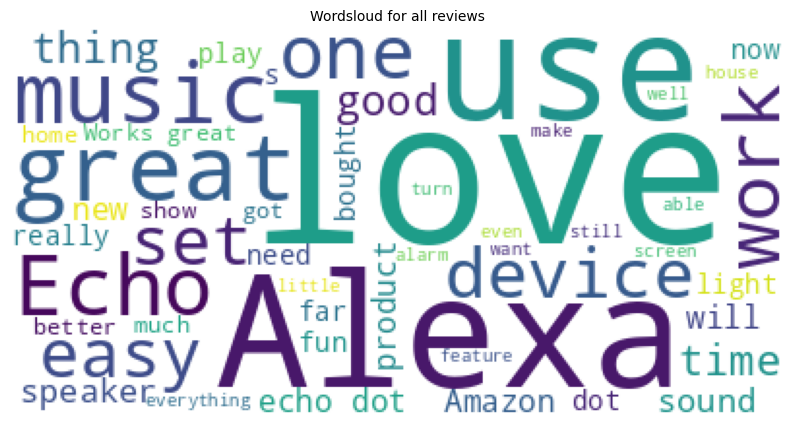

In [30]:
revirews=' '.join([review for review in data['verified_reviews']])

wc=WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(revirews))
plt.title('Wordsloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()


In [31]:
neg_reviews=' '.join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews=neg_reviews.lower().split()

pos_reviews=' '.join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews=pos_reviews.lower().split()


# finding words from review which are present in the that feedback category only
unique_negative =[x for x in neg_reviews if x not in pos_reviews]
unique_negative=' '.join(unique_negative)
unique_positive =[x for x in pos_reviews if x not in neg_reviews]
unique_positive=' '.join(unique_positive)



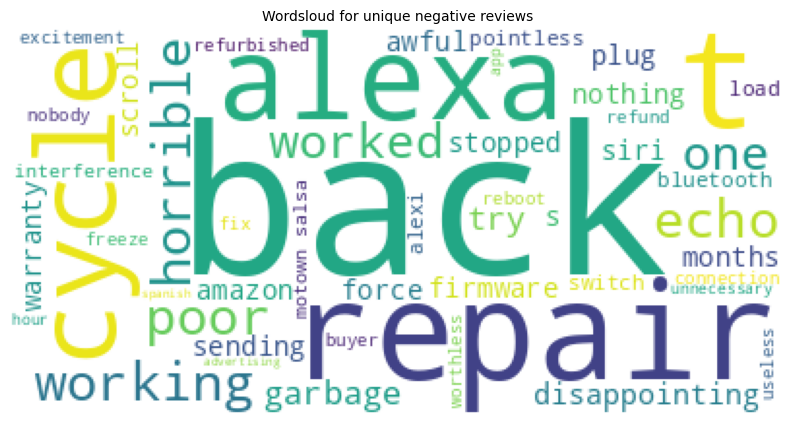

In [32]:
wc=WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordsloud for unique negative reviews', fontsize=10)
plt.axis('off')
plt.show()

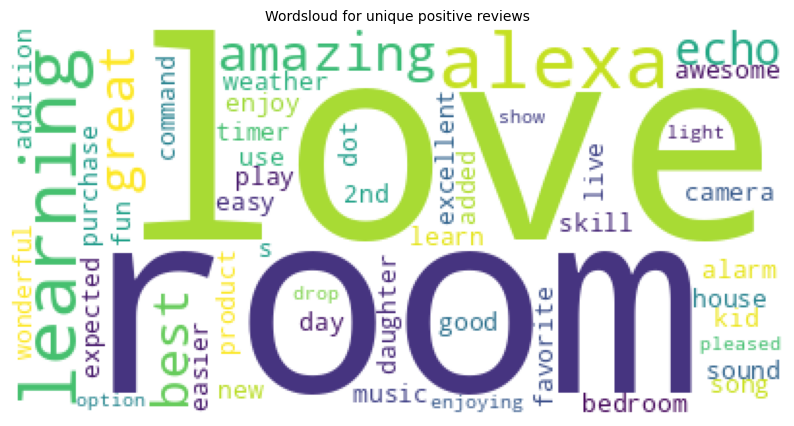

In [33]:
wc=WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordsloud for unique positive reviews', fontsize=10)
plt.axis('off')
plt.show()

### Preprocessing and modeling

In [34]:
corpus = []
stemmer = PorterStemmer()

for i in range(data.shape[0]):
    try:
        review = data['verified_reviews'][i]
    except KeyError:
        continue  # Skip if the index doesn't exist

    if pd.isna(review):
        continue  # Skip if the review is missing or NaN

    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)

    corpus.append(review)


In [35]:
cv=CountVectorizer(max_features=2500)
X=cv.fit_transform(corpus).toarray()
y=data['feedback'].values

In [36]:
import os
import pickle

# Create directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

# Save the pickle file
with open('Models/countVectoriser.pkl', 'wb') as f:
    pickle.dump(cv, f)


In [37]:
pickle.dump(cv,open('Models/countVectoriser.pkl','wb'))

In [38]:
# checking x and y shape

print(X.shape)
print(y.shape)

(3148, 2500)
(3149,)


In [39]:
y = y[:len(X)]  # Adjust y to match X


In [40]:
X = X[:len(y)]  # Adjust X to match y


In [41]:
import pandas as pd

# Convert X and y to DataFrame and Series, respectively
X_df = pd.DataFrame(X)
y_series = pd.Series(y)

# Concatenate and drop NaN values
combined = pd.concat([X_df, y_series], axis=1).dropna()

# Separate X and y after dropping NaN rows
X_clean = combined.iloc[:, :-1]  # All columns except the last one
y_clean = combined.iloc[:, -1]   # Last column as y

print(X_clean.shape, y_clean.shape)

# Print shapes to verify consistency
print(f"X_clean shape: {X_clean.shape}")
print(f"y_clean shape: {y_clean.shape}")


(3148, 2500) (3148,)
X_clean shape: (3148, 2500)
y_clean shape: (3148,)


In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=15)

print(f"X_train:{X_train.shape}")
print(f"X_test:{X_test.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_test:{y_test.shape}")


X_train:(2203, 2500)
X_test:(945, 2500)
y_train:(2203,)
y_test:(945,)


In [43]:
print(f"X_train mx value : {X_train.max()}")
print(f"X_test mx value : {X_test.max()}")

X_train mx value : 12
X_test mx value : 10


In [44]:
scaler=MinMaxScaler()

x_train_scl=scaler.fit_transform(X_train)
x_test_scl=scaler.transform(X_test)

In [45]:
# solving scaler model

pickle.dump(scaler,open('Models/scaler.pkl','wb'))

Random forst classifier

In [46]:
# fitting scaled x_train and y_train on random forest calssifier

model_rf=RandomForestClassifier()
model_rf.fit(x_train_scl,y_train)

RandomForestClassifier()

In [47]:
# accuracy scaled x_train and y_train on random forst

print(f"train accuracy : {model_rf.score(x_train_scl,y_train)}")
print(f"test accuracy : {model_rf.score(x_test_scl,y_test)}")

train accuracy : 0.994098955969133
test accuracy : 0.9365079365079365


In [48]:
# predicting on the test set

y_preds=model_rf.predict(x_test_scl)

In [49]:
# confusion matrixc

cm=confusion_matrix(y_test,y_preds)

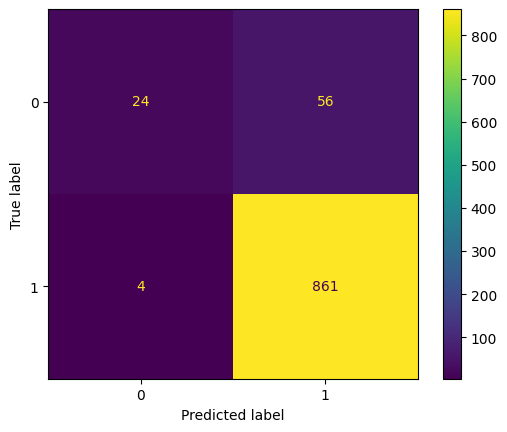

In [50]:
# confision matrcx display


cm_display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

###KFOLD CROSS VALIDATION

In [51]:
accuracies=cross_val_score(estimator=model_rf,X=x_train_scl,y=y_train,cv=10)

print("Accuracy :",accuracies)
print("Mean Accuracy :",accuracies.mean())
print("Standard Deviation :",accuracies.std())

Accuracy : [0.9321267  0.93665158 0.92760181 0.95       0.93181818 0.92272727
 0.93181818 0.94545455 0.93636364 0.93181818]
Mean Accuracy : 0.9346380090497737
Standard Deviation : 0.007625976669516715


In [56]:
# applying gridsearchcv to get optimal parameter on random forest

params={
    'bootstrap':[True],
    'max_depth':[80,100],
    'min_samples_split':[8,12],
    'n_estimators':[100,300]

}



In [57]:
cv_object=StratifiedKFold(n_splits=2)
grid_search=GridSearchCV(estimator=model_rf,param_grid=params,cv=cv_object,verbose=0,return_train_score=True)
grid_search.fit(x_train_scl,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [59]:
# getting best parameters from grid search cv

print("Best parameter combination : {}".format(grid_search.best_params_))

Best parameter combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [60]:
print("cross validtaion mean accuracy on train set: {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("cross validtaion mean accuracy on test set: {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for the test set :",accuracy_score(y_test,y_preds))

cross validtaion mean accuracy on train set: 96.5389233265914
cross validtaion mean accuracy on test set: 92.57826987839796
Accuracy score for the test set : 0.9365079365079365
